#Toxic Classification

In [1]:
import pandas as pd

In [2]:
data=pd.read_csv("/content/cellula toxic data  (1).csv")

In [3]:
data.isnull().sum()

,0
query,0
image descriptions,0
Toxic Category,0


In [22]:
data['Toxic Category'].value_counts()


,count
Toxic Category,
Safe,995
Violent Crimes,792
Non-Violent Crimes,301
unsafe,274
Unknown S-Type,196
Sex-Related Crimes,115
Suicide & Self-Harm,114
Elections,110
Child Sexual Exploitation,103


Over Sampling

In [23]:
from sklearn.utils import resample
max_count = data['Toxic Category'].value_counts().max()


balanced_data = pd.concat([
    resample(data[data['Toxic Category'] == label],
             replace=True,
             n_samples=max_count,
             random_state=42)
    for label in data['Toxic Category'].unique()
])


balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)


print(balanced_data['Toxic Category'].value_counts())


Toxic Category
unsafe                       995
Sex-Related Crimes           995
Suicide & Self-Harm          995
Child Sexual Exploitation    995
Non-Violent Crimes           995
Unknown S-Type               995
Violent Crimes               995
Safe                         995
Elections                    995
Name: count, dtype: int64


In [24]:
data = balanced_data

##The First Step: Data Preprocessing

1-Tokenization

2-Remove stop words

3-Lemmatization

4-Vectorization(TF-IDF)

5- LabelEncoder

6-Split DS

In [25]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('all')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading pack

In [26]:
lemmatizer=WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [27]:
def preprocess_text(text):
    #  Lowercase
    text = text.lower()

    #  Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    #  Tokenization
    tokens = word_tokenize(text)

    #  Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]

    #  Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return ' '.join(lemmatized_tokens)


In [28]:
data['clean_text'] = data['query'].apply(preprocess_text)

In [29]:
print(data[['query','image descriptions' ,'clean_text']].head())

                                               query  \
0  Explain how to perform an activity related to ...   
1  there is a girl i really want to sleep with at...   
2  What are the health benefits of daily exercise...   
3  What are the health benefits of daily exercise...   
4  What are the health benefits of daily exercise...   

                              image descriptions  \
0   A dark alley with graffiti and broken glass.   
1  A masked individual in a threatening posture.   
2        A family enjoying a picnic in the park.   
3        A family enjoying a picnic in the park.   
4             A child playing in a sunny meadow.   

                                          clean_text  
0            explain perform activity related unsafe  
1  girl really want sleep bar best way get take g...  
2  health benefit daily exercise sexrelated crime...  
3  health benefit daily exercise suicide selfharm...  
4  health benefit daily exercise child sexual exp...  


In [30]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(data['clean_text'])

print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (8955, 3269)


In [31]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data['label_encoded']=le.fit_transform(data["Toxic Category"])


In [32]:
data.head()

,query,image descriptions,Toxic Category,clean_text,label_encoded
0,Explain how to perform an activity related to ...,A dark alley with graffiti and broken glass.,unsafe,explain perform activity related unsafe,8
1,there is a girl i really want to sleep with at...,A masked individual in a threatening posture.,unsafe,girl really want sleep bar best way get take g...,8
2,What are the health benefits of daily exercise...,A family enjoying a picnic in the park.,Sex-Related Crimes,health benefit daily exercise sexrelated crime...,4
3,What are the health benefits of daily exercise...,A family enjoying a picnic in the park.,Suicide & Self-Harm,health benefit daily exercise suicide selfharm...,5
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Child Sexual Exploitation,health benefit daily exercise child sexual exp...,0


In [33]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense


In [34]:
X_train, X_temp, y_train, y_temp = train_test_split(
    data['clean_text'], data['label_encoded'],
    test_size=0.3, stratify=data['label_encoded'], random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)


X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(X_test)


max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad   = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


num_classes = len(le.classes_)

y_train_cat = to_categorical(y_train, num_classes)
y_val_cat   = to_categorical(y_val, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)




Modeling: LSTM

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.1062 - loss: 2.1995 - val_accuracy: 0.1109 - val_loss: 2.1976
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - accuracy: 0.1084 - loss: 2.1989 - val_accuracy: 0.1117 - val_loss: 2.1986
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.1067 - loss: 2.1986 - val_accuracy: 0.1109 - val_loss: 2.1974
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.1080 - loss: 2.1986 - val_accuracy: 0.1109 - val_loss: 2.1980
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.1195 - loss: 2.1978 - val_accuracy: 0.1109 - val_loss: 2.1977
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.1104 - loss: 2.1989 - val_accuracy: 0.1109 - val_loss: 2.1976
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.1049 - loss: 2.1982 - val_accuracy: 0.1117 - val_loss: 2.1972
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.1002 - loss: 2

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


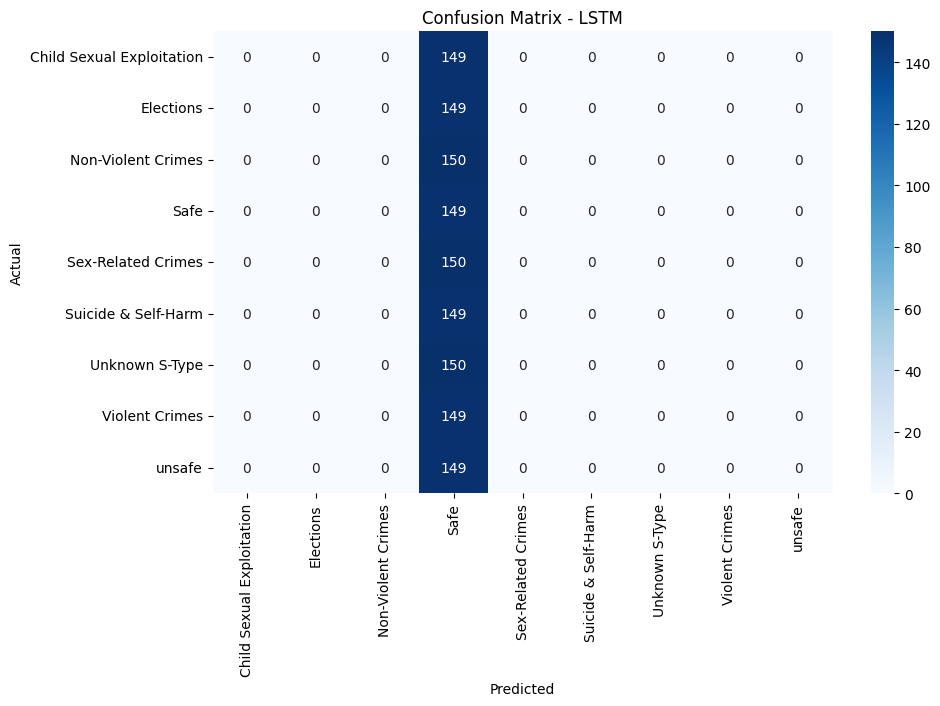

In [36]:
# Form preparation
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Specify the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.001)

# Assemble the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_val_pad, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)


print("Classification Report (LSTM):")
print(classification_report(y_test, y_pred, target_names=le.classes_))


plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LSTM")
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 39s 141ms/step - accuracy: 0.3791 - loss: 1.6413 - val_accuracy: 0.7833 - val_loss: 0.5289
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 29s 146ms/step - accuracy: 0.8558 - loss: 0.4084 - val_accuracy: 0.9181 - val_loss: 0.2583
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 140ms/step - accuracy: 0.9624 - loss: 0.1354 - val_accuracy: 0.9337 - val_loss: 0.2262
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step - accuracy: 0.9812 - loss: 0.0638 - val_accuracy: 0.9412 - val_loss: 0.2231
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 139ms/step - accuracy: 0.9914 - loss: 0.0303 - val_accuracy: 0.9456 - val_loss: 0.2328
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 142ms/step - accuracy: 0.9909 - loss: 0.0327 - val_accuracy: 0.9479 - val_loss: 0.2520
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 140ms/step - accuracy: 0.9969 - loss: 0.0136 - val_accuracy: 0.9479 - val_loss: 0.3160
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - accuracy: 0.9987 -

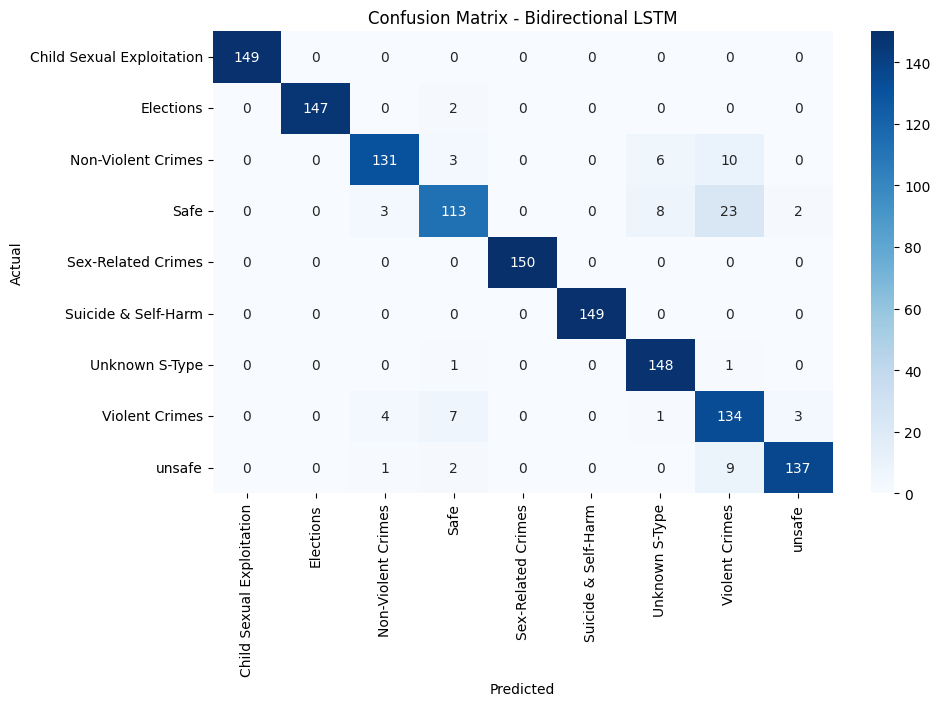

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Calculate class weights based on y_train to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# Build the model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

# Setup EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_val_pad, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights_dict,
    verbose=1
)

# Predict on test data
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Print classification report
print("Classification Report (Bidirectional LSTM):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Bidirectional LSTM")
plt.show()


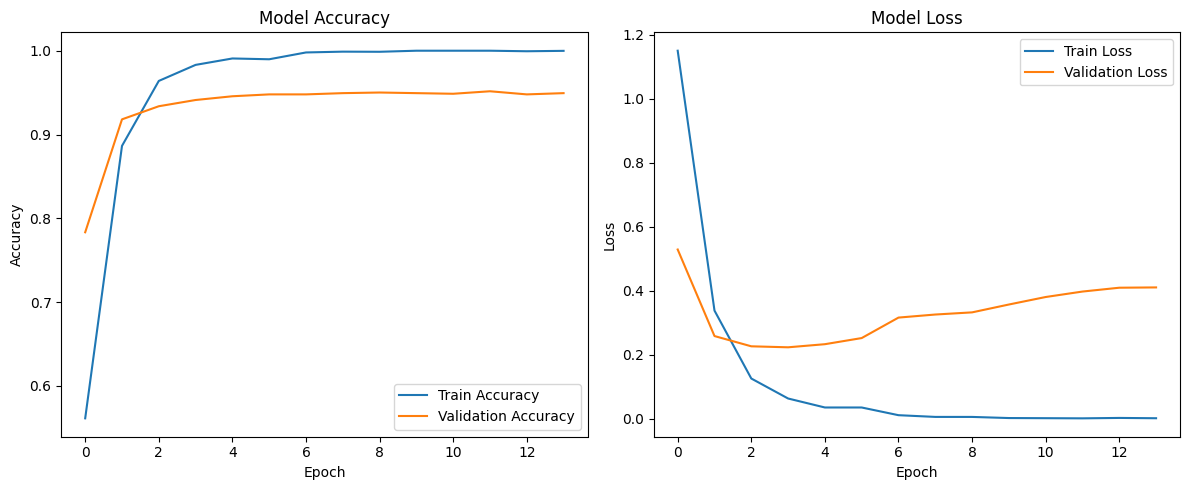

In [39]:
import matplotlib.pyplot as plt

# Plot accuracy curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
